# Analyse des données extraite via Graal

## Ouverture de data.csv et insertion dans df

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
#Fonction pour clean le data (le plus générale possible)
def cleanData(df,columns,vide):
    #on ajoute le header
    df.columns =columns
    #On récupère que les valeurs entre guillemets
    df= df.applymap(lambda x: re.search(r'(^.*"(.*)\")',str(x)).group(2))

    #Passage NaN au valeur aillant le mot vide
    for column in df.columns[0:]:
        df.loc[df[column]==vide,column]=np.nan
    return df


        
#on transforme en dataframe
df = pd.read_csv("data.csv", header=None)
#Définition du header
columns = ["boat","embarked","sex","age","firstname","lastname","parch","sibsp","ticket","pclass"]    
#indication du mot vide (modulable selon si c'est ?, Unknown,null, NULL etc)
vide = 'null'

df = cleanData(df,columns,vide)
df.head()


,boat,embarked,sex,age,firstname,lastname,parch,sibsp,ticket,pclass
0,NaN,S,male,NaN,Mr. Ingvald Olai Olsen,Hagland,0,1,65303,3
1,NaN,S,female,8.0,Miss. Torborg Danira,Palsson,1,3,349909,3
2,11,NaN,female,22.0,Miss. Alice,Cleaver,0,0,113781,1
3,9,NaN,female,24.0,Miss. Alice,Herman,2.0,1.0,220845,2
4,NaN,S,male,20.0,Mr. Domingos Fernandeo,Coelho,0,0,SOTON/O.Q. 3101307,3


## Ouverture de check.csv

In [97]:
dfSurvived = pd.read_csv("check.csv", header=None)
columns = ["firstname","lastname","survived"]   
dfSurvived = cleanData(dfSurvived,columns,vide)

## Fusion

In [98]:
df = pd.merge(df,dfSurvived, on=['firstname', 'lastname'])
df.head()

,boat,embarked,sex,age,firstname,lastname,parch,sibsp,ticket,pclass,survived
0,NaN,S,male,NaN,Mr. Ingvald Olai Olsen,Hagland,0,1,65303,3,0
1,NaN,S,female,8.0,Miss. Torborg Danira,Palsson,1,3,349909,3,0
2,11,NaN,female,22.0,Miss. Alice,Cleaver,0,0,113781,1,1
3,9,NaN,female,24.0,Miss. Alice,Herman,2.0,1.0,220845,2,1
4,NaN,S,male,20.0,Mr. Domingos Fernandeo,Coelho,0,0,SOTON/O.Q. 3101307,3,0


## Analyses des données

<AxesSubplot:>

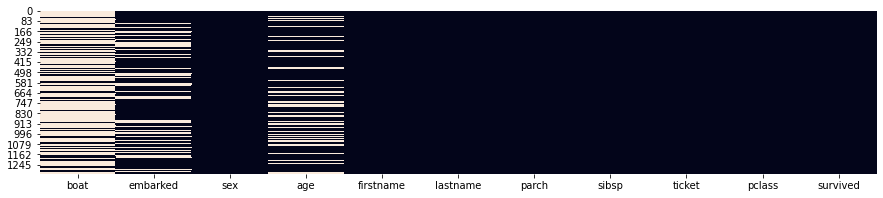

In [99]:
sns.heatmap(df.isnull(), cbar=False)

In [100]:
#transformation des zone numériques (object -> int/float)
df['pclass']=df['pclass'].astype(int)
df['survived']= df['survived'].astype(int)
df['parch']= df['parch'].astype(float)
df['sibsp']= df['sibsp'].astype(float)
df['age']= df['age'].astype(float)
df.describe(include=['O'])

,boat,embarked,sex,firstname,lastname,ticket
count,370,999,1320,1320,1320,1320
unique,73,179,2,1141,875,929
top,4,S,male,Mr. James,Andersson,CA. 2343
freq,32,498,849,15,11,11


In [101]:
df[['pclass', 'survived']].groupby(['pclass'], as_index=False).mean().sort_values(by='survived', ascending=False)

,pclass,survived
0,1,0.618012
1,2,0.429603
2,3,0.255201


In [102]:
df[["sex", "survived"]].groupby(['sex'], as_index=False).mean().sort_values(by='survived', ascending=False)

,sex,survived
0,female,0.723992
1,male,0.189635


In [103]:
df[["sibsp", "survived"]].groupby(['sibsp'], as_index=False).mean().sort_values(by='survived', ascending=False)

,sibsp,survived
1,1.0,0.509434
2,2.0,0.452381
0,0.0,0.345515
3,3.0,0.300000
4,4.0,0.136364
5,5.0,0.000000
6,8.0,0.000000


In [104]:
df[["parch", "survived"]].groupby(['parch'], as_index=False).mean().sort_values(by='survived', ascending=False)

,parch,survived
3,3.0,0.625000
1,1.0,0.588235
2,2.0,0.504425
0,0.0,0.333662
4,4.0,0.166667
5,5.0,0.166667
6,6.0,0.000000
7,9.0,0.000000


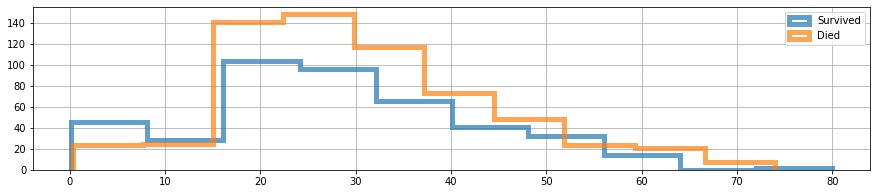

In [105]:
plt.rcParams["figure.figsize"] = (15,3)
#nombre de personnes en vie/morte suivant leur ages
df.loc[df["survived"] == 1,"age"].hist(alpha = 0.7,fill=False, histtype='step',linewidth=5);
df.loc[df["survived"] == 0,"age"].hist(alpha = 0.7,fill=False, histtype='step',linewidth=5).legend(["Survived","Died"]);

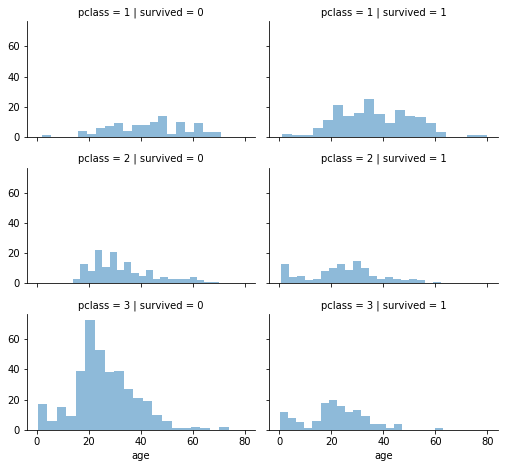

In [106]:
grid = sns.FacetGrid(df, col='survived', row='pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend();

Pour la classification il faut :
    numéroter les age selon une periode ex : [0,5] = 1  [5,10]=2 ....
    numéroter les fare selon une tranche de prix
    attribuer un chiffre a chaque lettre de embarked
    attribuer un chiffe a chaque sex
    attribuer un chiffre pour la partie nom:
        On peut s'intéresser uniquement au nom de famille a qui on attribut un chiffre
        On  peut s'intéresser uniquement à la classe sociale "miss" , "mister"..
    s'interesser au sibsp, parch de façons différente
        seulement notifier si la personne est seul
        additionner les deux et faire une tranche 0 = 0  [1,3] = 1, [4,6]=2 ....